In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df_fields = pd.read_csv('../data/fields.csv', delimiter=';', decimal=',', skiprows=[0, 2])
df_value = pd.read_csv('../data/value.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['inv_item_date'], date_format={'inv_item_date': '%d.%m.%Y'})
df_works = pd.read_csv('../data/works.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['start_date', 'end_date'], date_format={'start_date': '%d.%m.%Y', 'end_date': '%d.%m.%Y'})

df_works['area'] = df_works['area'].str.replace(',', '.').astype(float)

In [12]:
valid_work_subtypes = ['Прямое комбайнирование', 'Подбор и обмолот', 'Заготовка сенажа', 'Уборка силос/карнаж', 'Подбор (корм)', 'Вывоз', 'Прессование']
valid_work_types = ['Обработка почвы', 'Уборка']

df_yield_fact_works = df_works.query(
    f"work_type in {valid_work_types} and work_subtype in {valid_work_subtypes}"
)[['season', 'field', 'yield_fact', 'area', 'work_type']]

df_yield_fact = (
    df_yield_fact_works
    .assign(weighted_yield=lambda x: x['yield_fact'] * x['area'])
    .groupby(['field', 'season'])
    .agg(weighted_yield=('weighted_yield', 'sum'), total_area=('area', 'sum'))
    .assign(weighted_mean=lambda x: x['weighted_yield'] / x['total_area'])
    .reset_index()[['field', 'season', 'weighted_mean']]
)

df_yield_fact = df_yield_fact.rename(columns={'weighted_mean': 'yield_fact'})

df_yield_fact.head()

,field,season,yield_fact
0,02.09.02.002.01,2023,1.568170
1,02.09.02.002.01,2024,0.000000
2,02.09.02.015.00,2023,1.223696
3,02.09.02.019.00,2023,2.150000
4,02.09.03.032.00,2023,268.696209


In [13]:
df_fields_tmp = df_fields[['season', 'field', 'p2o5', 'k2o', 'humus', 'ph', 'crop', 'region', 'yield_plan']]

df = df_fields_tmp.merge(df_yield_fact, how='left', on=['field', 'season']) #.dropna(subset=['yield_fact', 'yield_plan'])

df = df.dropna()

df.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405
3,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617
4,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186
7,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347
9,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071


In [14]:
df['fact_plan_dif'] = df['yield_fact'] - df['yield_plan']
df['fact_plan_dif_abs'] = abs(df['fact_plan_dif'])
df['fact_plan_div'] = df['fact_plan_dif'] / df['yield_plan']
df['fact_plan_share_dif'] = df['yield_fact'] / df['yield_plan'] - 1

In [15]:
def remove_outliers_iqr(df, column, k = 1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [16]:
df = remove_outliers_iqr(df, 'yield_fact', k=1.5)

In [17]:
import statsmodels.api as sm

In [85]:
x = df[['humus', 'k2o', 'p2o5', 'ph']]
y = df['fact_plan_dif']

model = sm.OLS(y, sm.add_constant(x)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          fact_plan_dif   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     42.82
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           1.59e-35
Time:                        09:16:50   Log-Likelihood:                -13009.
No. Observations:                6759   AIC:                         2.603e+04
Df Residuals:                    6754   BIC:                         2.606e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9973      0.165    -12.079      0.0

In [89]:
x = df['ph']
y = df['fact_plan_dif']

model = sm.OLS(y, sm.add_constant(x)).fit()

print(model.summary())

y_pred = model.predict(sm.add_constant(x))

# plt.scatter(x, y, label="Данные", alpha=0.7)
# plt.plot(x, y_pred, label="Регрессия", color="red")
# plt.legend()
# plt.title("p2o5")
# plt.show()

                            OLS Regression Results                            
Dep. Variable:          fact_plan_dif   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03170
Date:                Sat, 14 Dec 2024   Prob (F-statistic):              0.859
Time:                        09:19:40   Log-Likelihood:                -13094.
No. Observations:                6759   AIC:                         2.619e+04
Df Residuals:                    6757   BIC:                         2.620e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9185      0.161    -11.929      0.0

In [ ]:
tmp = df.query(f"crop == 'Соя' and region == 'Воронеж'")
# tmp = tmp[tmp['fact_plan_dif'] < 2]

X = tmp['humus']
y = tmp['fact_plan_dif']

model = sm.OLS(y, X).fit()

print(model.summary())

y_pred = model.predict(X)

plt.scatter(X, y, label="Данные", alpha=0.7)
plt.plot(X, y_pred, color="red", label="Линейная регрессия")
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.title("Линейная регрессия")
plt.show()

                                 OLS Regression Results                                
Dep. Variable:          fact_plan_dif   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.637
Method:                 Least Squares   F-statistic:                              544.7
Date:                Sat, 14 Dec 2024   Prob (F-statistic):                    3.67e-70
Time:                        08:49:59   Log-Likelihood:                         -318.79
No. Observations:                 310   AIC:                                      639.6
Df Residuals:                     309   BIC:                                      643.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

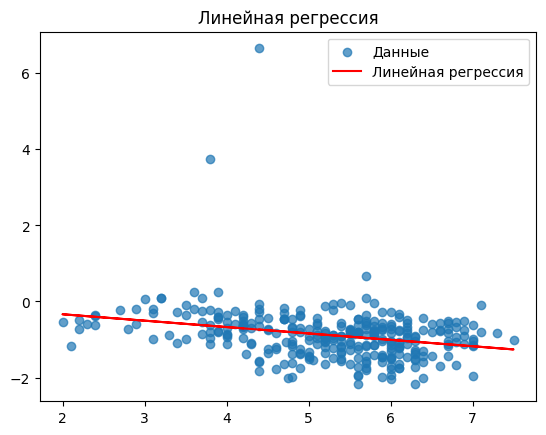

In [67]:
y_pred = model.predict(X)

plt.scatter(X, y, label="Данные", alpha=0.7)
plt.plot(X, y_pred, color="red", label="Линейная регрессия")
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.title("Линейная регрессия")
plt.show()

In [40]:
top_crops = df['crop'].value_counts().head(5).index.to_list()
top_crops

['Кукуруза силос',
 'Люцерна пр.лет корм',
 'Оз.пшеница мягкая',
 'Соя',
 'Яр.пшеница мягкая']

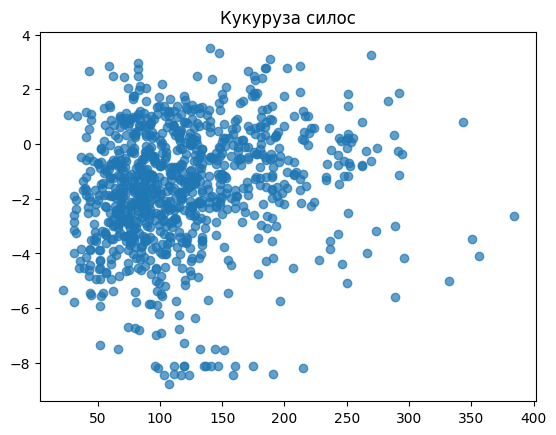

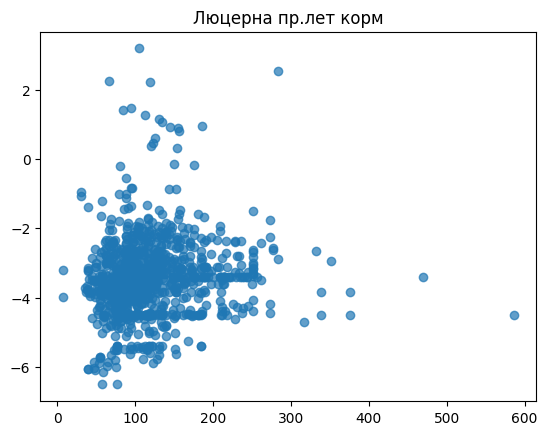

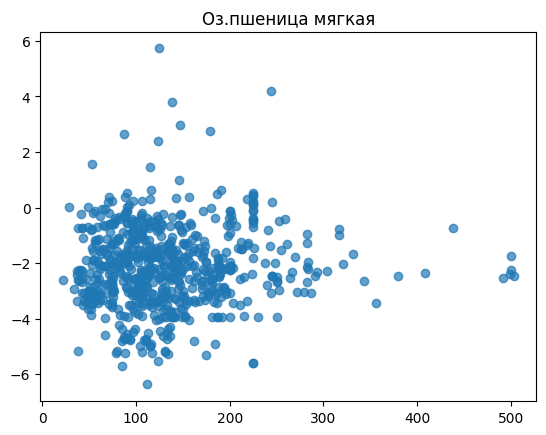

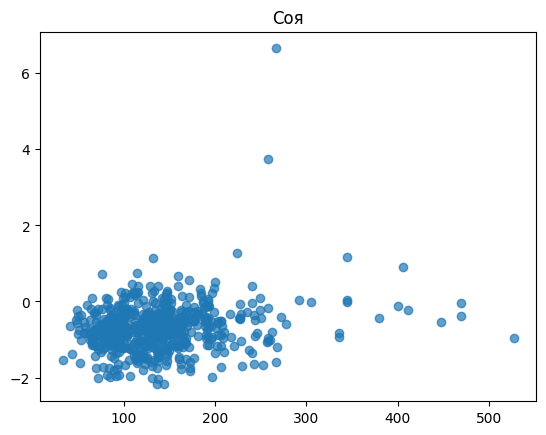

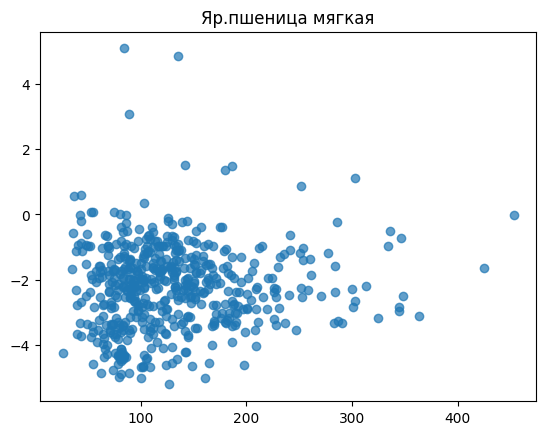

In [28]:
for crop in top_crops:
    X = df[df['crop'] == crop]['k2o'] # .boxplot(column=['fact_plan_dif'], figsize=(10, 6))
    y = df[df['crop'] == crop]['fact_plan_dif']

    plt.scatter(X, y, label="Данные", alpha=0.7)

    plt.title(f'{crop}')
    plt.show()

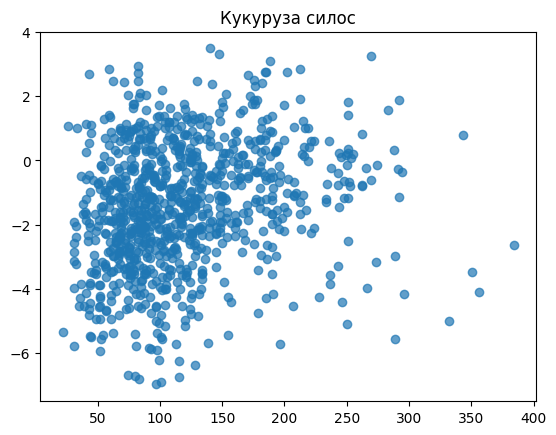

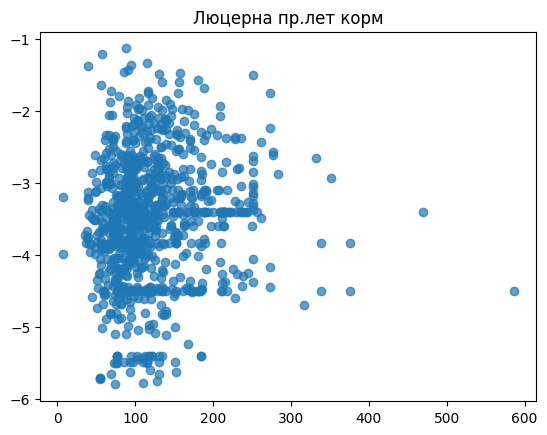

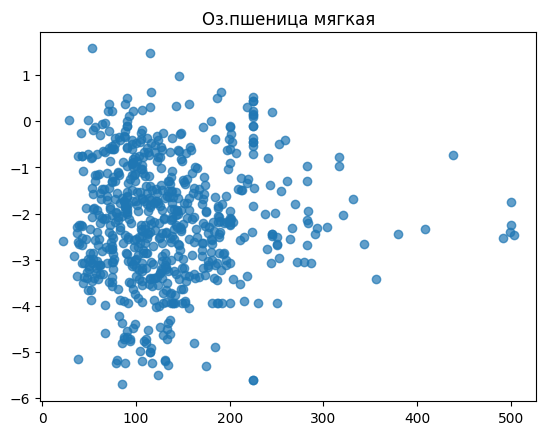

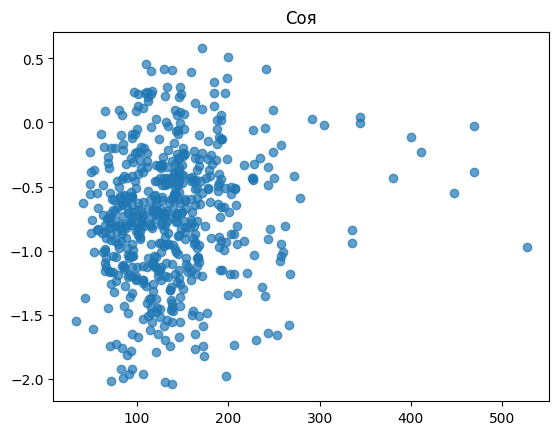

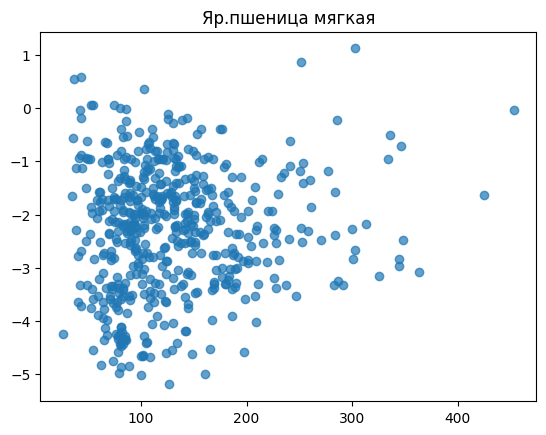

In [29]:
for crop in top_crops:
    tmp = remove_outliers_iqr(df[df['crop'] == crop], 'fact_plan_dif')

    X = tmp['k2o']
    y = tmp['fact_plan_dif']

    plt.scatter(X, y, label="Данные", alpha=0.7)

    plt.title(f'{crop}')
    plt.show()

In [25]:
top_regions = df['region'].value_counts().head(5).index.to_list()
top_regions

['Воронеж', 'Калуга', 'Рязань', 'Курск', 'Татарстан']

In [47]:
for region in top_regions:
    for crop in top_crops:
        tmp = df.query(f"crop == '{crop}' and region == '{region}'")

        if tmp.shape[0] <= 0:
            continue
            
        for f in ['k2o', 'humus']:
            X = tmp[f]
            y = tmp['fact_plan_dif']

            model = sm.OLS(y, sm.add_constant(X)).fit()

            if model.rsquared < 0.1:
                continue

            print(f"Region: {region}, Crop: {crop}, Feature: {f}")

            print(model.summary())

Region: Воронеж, Crop: Яр.пшеница мягкая, Feature: k2o
                            OLS Regression Results                            
Dep. Variable:          fact_plan_dif   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.609
Date:                Sat, 14 Dec 2024   Prob (F-statistic):             0.0413
Time:                        08:03:38   Log-Likelihood:                -35.871
No. Observations:                  28   AIC:                             75.74
Df Residuals:                      26   BIC:                             78.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

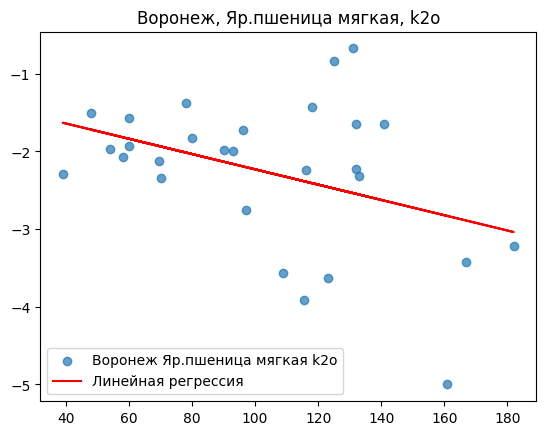

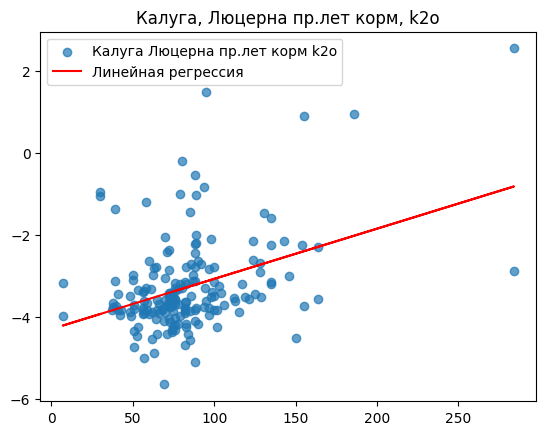

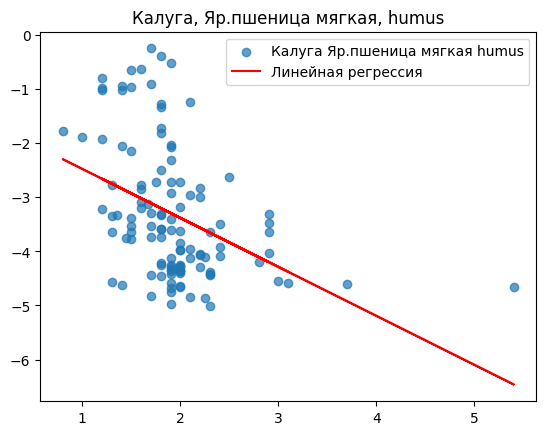

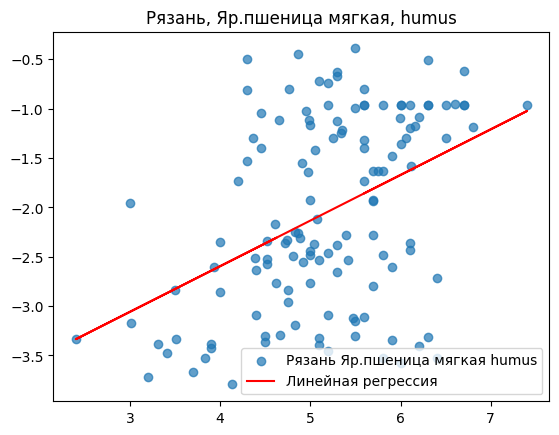

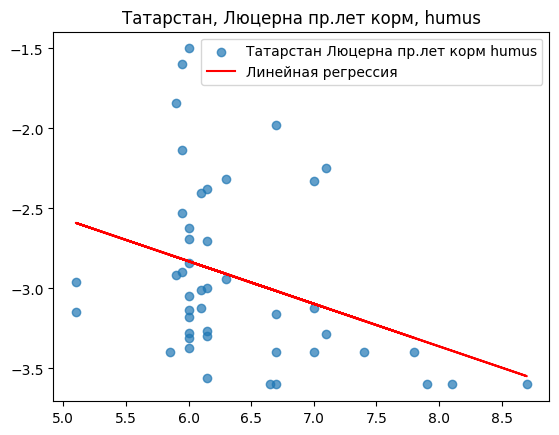

In [52]:
for region in top_regions:
    for crop in top_crops:
        tmp = df.query(f"crop == '{crop}' and region == '{region}'")

        if tmp.shape[0] <= 0:
            continue
            
        for f in ['k2o', 'humus']:
            X = tmp[f]
            y = tmp['fact_plan_dif']

            model = sm.OLS(y, sm.add_constant(X)).fit()

            if model.rsquared < 0.1:
                continue

            y_pred = model.predict(sm.add_constant(X))

            plt.scatter(X, y, label=f"{region} {crop} {f}", alpha=0.7)
            plt.plot(X, y_pred, color="red", label="Линейная регрессия")
            plt.xlabel("")
            plt.ylabel("")
            plt.legend()
            plt.title(f"{region}, {crop}, {f}")
            plt.show()

In [70]:
for region in top_regions:
    for crop in top_crops:
        tmp = df.query(f"crop == '{crop}' and region == '{region}'")

        if tmp.shape[0] <= 0:
            continue
            
        # for f in ['k2o', 'humus']:
        X = tmp[['k2o', 'humus', 'p2o5', 'ph']]
        y = tmp['fact_plan_dif']

        model = sm.OLS(y, sm.add_constant(X)).fit()

        if model.rsquared < 0.1:
            continue
        
        print(f"Region: {region}, Crop: {crop}")
        print(model.summary())

        # y_pred = model.predict(sm.add_constant(X))

            # plt.scatter(X, y, label=f"{region} {crop} {f}", alpha=0.7)
            # plt.plot(X, y_pred, color="red", label="Линейная регрессия")
            # plt.xlabel("")
            # plt.ylabel("")
            # plt.legend()
            # plt.title(f"{region}, {crop}, {f}")
            # plt.show()

Region: Воронеж, Crop: Оз.пшеница мягкая
                            OLS Regression Results                            
Dep. Variable:          fact_plan_dif   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     12.30
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           6.42e-09
Time:                        08:55:03   Log-Likelihood:                -351.60
No. Observations:                 196   AIC:                             713.2
Df Residuals:                     191   BIC:                             729.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      